In [ ]:
!pip install -q transformers==4.37.2 --quiet
!pip install pydot --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 18.1 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel
from keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/w266_project')
p = os.path.abspath('.')
raw_data_path = os.path.join(p, 'new_raw_data.csv')
df = pd.read_csv(raw_data_path, header = 0, sep="\t", index_col=0)


Mounted at /content/drive


In [ ]:
# Test/train split
X = np.vstack(df['Abstract'])
y = df['JIF']
train_texts, valid_texts, train_labels, test_labels = train_test_split(X, y, test_size=0.3, random_state=42)
valid_labels = np.array(test_labels)
train_labels = np.array(train_labels)

# How many dense layers? Use BERT as an example.

In [ ]:
# Load BERT tokenizer and model
model_checkpoint = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture

In [ ]:
max_length = 400
train_encodings = bert_tokenizer(list(train_texts[:,0]), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(list(valid_texts[:,0]), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [ ]:
def create_bert_regression_model(checkpoint = bert_model,
                                 hidden_size = 768,
                                 num_hid = 0,
                                 dropout=0.3,
                                 learning_rate=0.0001):
    bert_model.trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    #token = bert_out[1] #pooler token
    token = bert_out[0][:, 0, :] #cls token

    if num_hid == 0:
      regression = tf.keras.layers.Dense(1, activation='linear', name='regression_layer')(token)

    elif num_hid == 1:
      hidden1 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer1')(token)
      hidden1 = tf.keras.layers.Dropout(dropout)(hidden1)
      regression = tf.keras.layers.Dense(1, activation='linear', name='regression_layer')(hidden1)

    elif num_hid == 2:
      hidden1 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer1')(token)
      hidden1 = tf.keras.layers.Dropout(dropout)(hidden1)
      hidden2 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer2')(hidden1)
      hidden2 = tf.keras.layers.Dropout(dropout)(hidden2)
      regression = tf.keras.layers.Dense(1, activation='linear', name='regression_layer')(hidden2)

    else:
      print('Error')

    regression_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[regression])
    regression_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.mean_squared_error,
                                 metrics= [tf.keras.metrics.mean_squared_error])
    return regression_model

In [ ]:
#Set up early stopping monitor
early_stopping = EarlyStopping(monitor='val_mean_squared_error',
                               patience=5,
                               mode = "auto",
                               restore_best_weights=True)

## BERT with no dense layers

In [ ]:
regression_bert_model_0 = create_bert_regression_model(checkpoint=bert_model, num_hid = 0)

In [ ]:
bert_history_0 = regression_bert_model_0.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                                  train_labels,
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
                                                  valid_labels),
                                                  batch_size=8,
                                                  epochs=60, callbacks=[early_stopping])

Epoch 1/60
397/397 [==============================] - 69s 147ms/step - loss: 6.1732 - mean_squared_error: 6.1732 - val_loss: 5.2125 - val_mean_squared_error: 5.2125
Epoch 2/60
397/397 [==============================] - 54s 137ms/step - loss: 4.5333 - mean_squared_error: 4.5333 - val_loss: 4.8714 - val_mean_squared_error: 4.8714
Epoch 3/60
397/397 [==============================] - 54s 137ms/step - loss: 4.3551 - mean_squared_error: 4.3551 - val_loss: 4.6711 - val_mean_squared_error: 4.6711
Epoch 4/60
397/397 [==============================] - 50s 126ms/step - loss: 4.1971 - mean_squared_error: 4.1971 - val_loss: 4.5951 - val_mean_squared_error: 4.5951
Epoch 5/60
397/397 [==============================] - 55s 138ms/step - loss: 4.1639 - mean_squared_error: 4.1639 - val_loss: 4.3983 - val_mean_squared_error: 4.3983
Epoch 6/60
397/397 [==============================] - 55s 138ms/step - loss: 4.0373 - mean_squared_error: 4.0373 - val_loss: 4.3303 - val_mean_squared_error: 4.3303
Epoch 7/60

In [ ]:
pred_0 = regression_bert_model_0.predict([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask])
pred_0 = pred_0.reshape((-1))

43/43 [==============================] - 16s 293ms/step


Text(0, 0.5, 'Observed')

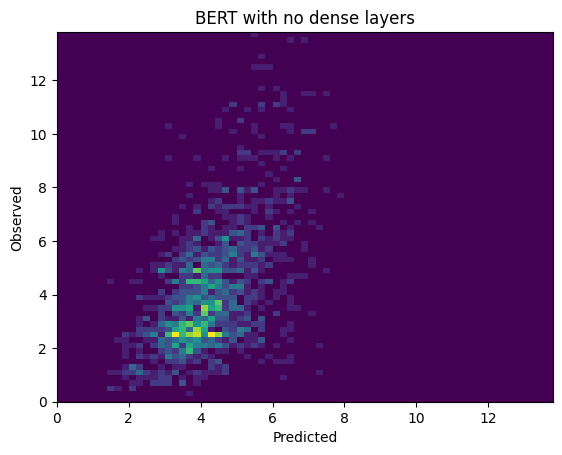

In [ ]:
fig, ax = plt.subplots()
ax.hist2d(pred_0, valid_labels , bins=(np.arange(0, 14, 0.2), np.arange(0, 14, 0.2)))
ax.set_title('BERT with no dense layers')
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')

In [ ]:
np.corrcoef(pred_0, valid_labels)

array([[1.        , 0.53503334],
       [0.53503334, 1.        ]])

In [ ]:
# Save the resulting data
df_to_save = pd.DataFrame({'Predicted':pred_0, 'Observed':valid_labels})
result_path = os.path.join(p, 'results_csv', 'BERT_0dense_result')
df_to_save.to_csv(result_path, sep = '\t')

## BERT with 1 dense layer

In [ ]:
regression_bert_model_1 = create_bert_regression_model(checkpoint=bert_model, num_hid = 1)

In [ ]:
bert_history_1 = regression_bert_model_1.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                                  train_labels,
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
                                                  valid_labels),
                                                  batch_size=8,
                                                  epochs=60, callbacks=[early_stopping])

Epoch 1/60
397/397 [==============================] - 67s 146ms/step - loss: 4.5452 - mean_squared_error: 4.5452 - val_loss: 4.1062 - val_mean_squared_error: 4.1062
Epoch 2/60
397/397 [==============================] - 54s 137ms/step - loss: 3.9596 - mean_squared_error: 3.9596 - val_loss: 4.1744 - val_mean_squared_error: 4.1744
Epoch 3/60
397/397 [==============================] - 55s 138ms/step - loss: 3.8965 - mean_squared_error: 3.8965 - val_loss: 3.7433 - val_mean_squared_error: 3.7433
Epoch 4/60
397/397 [==============================] - 55s 137ms/step - loss: 3.7657 - mean_squared_error: 3.7657 - val_loss: 4.0032 - val_mean_squared_error: 4.0032
Epoch 5/60
397/397 [==============================] - 55s 139ms/step - loss: 3.7086 - mean_squared_error: 3.7086 - val_loss: 3.7351 - val_mean_squared_error: 3.7351
Epoch 6/60
397/397 [==============================] - 54s 137ms/step - loss: 3.6724 - mean_squared_error: 3.6724 - val_loss: 4.1820 - val_mean_squared_error: 4.1820
Epoch 7/60

In [ ]:
pred_1 = regression_bert_model_1.predict([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask])
pred_1 = pred_1.reshape((-1))

df_to_save = pd.DataFrame({'Predicted':pred_1, 'Observed':valid_labels})

result_path = os.path.join(p, 'results_csv', 'BERT_1dense_result')
df_to_save.to_csv(result_path, sep = '\t')

43/43 [==============================] - 15s 292ms/step


Text(0, 0.5, 'Observed')

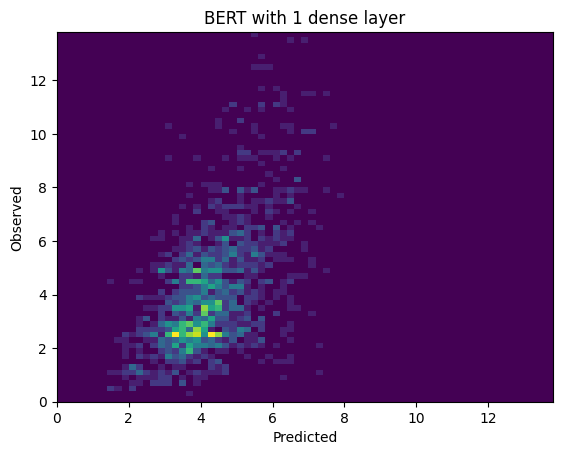

In [ ]:
fig, ax = plt.subplots()
ax.hist2d(pred_0, valid_labels , bins=(np.arange(0, 14, 0.2), np.arange(0, 14, 0.2)))
ax.set_title('BERT with 1 dense layer')
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')

In [ ]:
np.corrcoef(pred_1, valid_labels)

array([[1.        , 0.56287042],
       [0.56287042, 1.        ]])

##BERT w 2 desne layers

In [ ]:
regression_bert_model_2 = create_bert_regression_model(checkpoint=bert_model, num_hid = 2)
bert_history_2 = regression_bert_model_2.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                                  train_labels,
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
                                                  valid_labels),
                                                  batch_size=8,
                                                  epochs=60, callbacks=[early_stopping])

Epoch 1/60
397/397 [==============================] - 62s 135ms/step - loss: 4.5840 - mean_squared_error: 4.5840 - val_loss: 4.0605 - val_mean_squared_error: 4.0605
Epoch 2/60
397/397 [==============================] - 55s 137ms/step - loss: 4.0882 - mean_squared_error: 4.0882 - val_loss: 3.9473 - val_mean_squared_error: 3.9473
Epoch 3/60
397/397 [==============================] - 55s 138ms/step - loss: 3.9553 - mean_squared_error: 3.9553 - val_loss: 3.7961 - val_mean_squared_error: 3.7961
Epoch 4/60
397/397 [==============================] - 54s 137ms/step - loss: 3.7813 - mean_squared_error: 3.7813 - val_loss: 3.7228 - val_mean_squared_error: 3.7228
Epoch 5/60
397/397 [==============================] - 54s 137ms/step - loss: 3.7526 - mean_squared_error: 3.7526 - val_loss: 3.7350 - val_mean_squared_error: 3.7350
Epoch 6/60
397/397 [==============================] - 55s 138ms/step - loss: 3.7438 - mean_squared_error: 3.7438 - val_loss: 3.7036 - val_mean_squared_error: 3.7036
Epoch 7/60

In [ ]:
pred_2 = regression_bert_model_2.predict([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask])
pred_2 = pred_2.reshape((-1))

df_to_save = pd.DataFrame({'Predicted':pred_2, 'Observed':valid_labels})
result_path = os.path.join(p, 'results_csv', 'BERT_2dense_result')
df_to_save.to_csv(result_path, sep = '\t')

43/43 [==============================] - 16s 294ms/step


Text(0, 0.5, 'Observed')

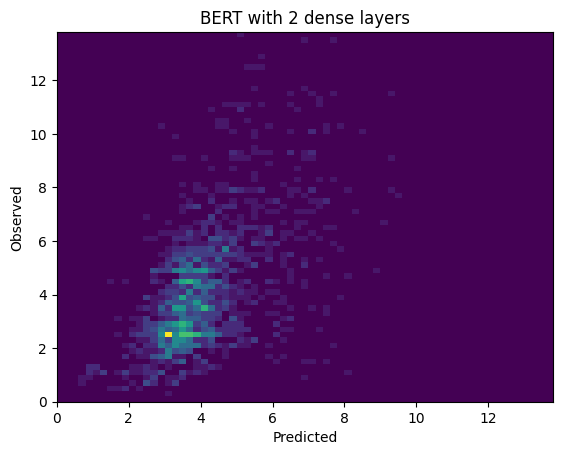

In [ ]:
fig, ax = plt.subplots()
ax.hist2d(pred_2, valid_labels , bins=(np.arange(0, 14, 0.2), np.arange(0, 14, 0.2)))
ax.set_title('BERT with 2 dense layers')
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')

In [ ]:
np.corrcoef(pred_2, valid_labels)

array([[1.       , 0.5525665],
       [0.5525665, 1.       ]])

## sciBERT vs BERT

In [ ]:
# Load SciBERT tokenizer and model
model_checkpoint = "allenai/scibert_scivocab_uncased"
sci_bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
sci_bert_model = TFBertModel.from_pretrained(model_checkpoint, from_pt=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [ ]:
max_length = 400
sci_train_encodings = sci_bert_tokenizer(list(train_texts[:,0]), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
sci_valid_encodings = sci_bert_tokenizer(list(valid_texts[:,0]), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [ ]:
def create_scibert_regression_model(checkpoint = sci_bert_model,
                                 hidden_size = 768,
                                 dropout=0.3,
                                 learning_rate=0.0001):
    sci_bert_model.trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = sci_bert_model(bert_inputs)

    #token = bert_out[1] #pooler token
    token = bert_out[0][:, 0, :] #cls token

    hidden1 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer1')(token)
    hidden1 = tf.keras.layers.Dropout(dropout)(hidden1)

    regression = tf.keras.layers.Dense(1, activation='linear', name='regression_layer')(hidden1)

    regression_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[regression])
    regression_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.mean_squared_error,
                                 metrics= [tf.keras.metrics.mean_squared_error])
    return regression_model

In [ ]:
sci_bert_model = create_scibert_regression_model(checkpoint=sci_bert_model)

In [ ]:
sci_bert_history = sci_bert_model.fit([sci_train_encodings.input_ids, sci_train_encodings.token_type_ids, sci_train_encodings.attention_mask],
                                                  train_labels,
                                                  validation_data=([sci_valid_encodings.input_ids, sci_valid_encodings.token_type_ids, sci_valid_encodings.attention_mask],
                                                  valid_labels),
                                                  batch_size=8,
                                                  epochs=60, callbacks=[early_stopping])

Epoch 1/60
397/397 [==============================] - 68s 147ms/step - loss: 4.0192 - mean_squared_error: 4.0192 - val_loss: 3.5695 - val_mean_squared_error: 3.5695
Epoch 2/60
397/397 [==============================] - 54s 137ms/step - loss: 3.3898 - mean_squared_error: 3.3898 - val_loss: 4.2811 - val_mean_squared_error: 4.2811
Epoch 3/60
397/397 [==============================] - 55s 140ms/step - loss: 3.1897 - mean_squared_error: 3.1897 - val_loss: 3.3730 - val_mean_squared_error: 3.3730
Epoch 4/60
397/397 [==============================] - 55s 138ms/step - loss: 3.0679 - mean_squared_error: 3.0679 - val_loss: 3.3572 - val_mean_squared_error: 3.3572
Epoch 5/60
397/397 [==============================] - 50s 125ms/step - loss: 3.0598 - mean_squared_error: 3.0598 - val_loss: 3.3376 - val_mean_squared_error: 3.3376
Epoch 6/60
397/397 [==============================] - 54s 137ms/step - loss: 2.9954 - mean_squared_error: 2.9954 - val_loss: 3.2836 - val_mean_squared_error: 3.2836
Epoch 7/60

In [ ]:
pred_sci = sci_bert_model.predict([sci_valid_encodings.input_ids, sci_valid_encodings.token_type_ids, sci_valid_encodings.attention_mask])
pred_sci = pred_sci.reshape((-1))

df_to_save = pd.DataFrame({'Predicted':pred_sci, 'Observed':valid_labels})
result_path = os.path.join(p, 'results_csv', 'sciBERT_1dense_result')
df_to_save.to_csv(result_path, sep = '\t')

43/43 [==============================] - 15s 294ms/step


In [ ]:
np.corrcoef(pred_sci, valid_labels)

array([[1.        , 0.63168977],
       [0.63168977, 1.        ]])

Text(0, 0.5, 'Observed')

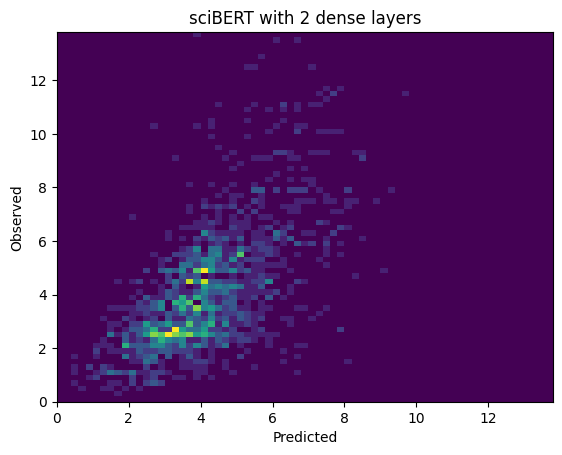

In [ ]:
fig, ax = plt.subplots()
ax.hist2d(pred_sci, valid_labels , bins=(np.arange(0, 14, 0.2), np.arange(0, 14, 0.2)))
ax.set_title('sciBERT with 1 dense layer')
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')